<a href="https://colab.research.google.com/github/LudovicaCataneo/AMLproject/blob/main/Applied_Machine_Learning_MNIST_CataneoLudovica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Applied Machine Learning - MNIST Project**
---
##University of Bologna - Italy

##Bioinformatics

*Ludovica Cataneo*

---

**MNIST database** (*Modified National Institute of Standards and Technology database*)  is a large database of handwritten digits (0 to 9) that is commonly used for training various image processing systems. The database contains 60,000 training images and 10,000 testing images each of size 28x28. 

Since its release in 1999, this classic dataset of has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

##**Aim of the project**
The goal of this project is to produce a handwriting classifier based on different Machine Learning approaches:
- Decision Tree
- Random Forest
- Convolutional Neural Networks

We will compare them and discuss their differences in terms of performance and accuracy.

## Loading and visualizing data
---

In [1]:
#This is a useful tool able to estimate the time needed to run each cell
!pip install ipython-autotime
%load_ext autotime


time: 1.63 ms (started: 2021-04-09 15:05:43 +00:00)


### Import modules

In [2]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
# numpy
import numpy as np
# matplotlib
import matplotlib.pyplot as plt
# seaborn
import seaborn as sns

time: 1.82 s (started: 2021-04-09 15:05:43 +00:00)


###Import data 

The MNIST dataset is conveniently provided to us as part of the *Keras library*, so we can easily load the dataset. Out of the 70,000 images provided in the dataset, 60,000 are given for training and 10,000 are given for testing.

When we load the dataset:
- *train_images* and *test_images* will contain all the images
- *train_labels* and *test_labels* will contain the digits related to each image. 

In [3]:
#download mnist data and split into train and test sets
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


11493376/11490434 [==============================] - 0s 0us/step
time: 467 ms (started: 2021-04-09 15:05:45 +00:00)


### Data exploration
Check for the dataset *dimension*.

In [4]:
print('Training images:', train_images.shape)
print('Number of training labels:', len(train_labels))
print('Testing images:', test_images.shape)
print('Number of testing labels:', len(test_labels))

Training images: (60000, 28, 28)
Number of training labels: 60000
Testing images: (10000, 28, 28)
Number of testing labels: 10000
time: 2.69 ms (started: 2021-04-09 15:05:46 +00:00)


*Visualize*  data randomly selected from the training set, in order to see the images and the related labels.

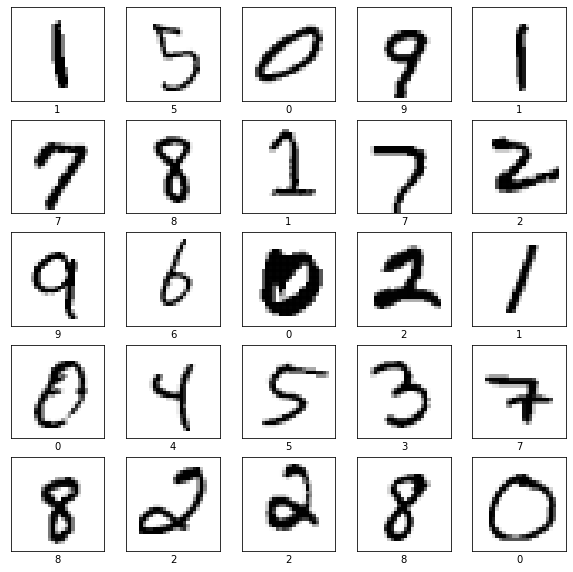

time: 757 ms (started: 2021-04-09 15:05:46 +00:00)


In [5]:
#set figure dimension
plt.figure(figsize=(10,10))

#pick 25 random digits
random_inds = np.random.choice(60000,25)
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image_ind = random_inds[i]
  #show images using a binary color map
  plt.imshow(train_images[image_ind], cmap=plt.cm.binary)
  plt.xlabel(train_labels[image_ind])
plt.show()

Explore the *class distribution*.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0.5, 'classes counts'), Text(0.5, 0, 'classes')]

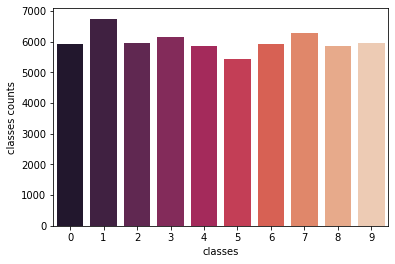

time: 191 ms (started: 2021-04-09 15:05:46 +00:00)


In [6]:
count_plot = sns.countplot(train_labels, palette="rocket")
count_plot.set(xlabel='classes', ylabel='classes counts')

## Data pre-processing
---

In any Machine Learning process, data preprocessing is that step in which data gets transformed to bring it to such a state that the machine can  better understand and interpret it. 

**Deskewing** is the process of straightening an image that has been scanned or written crookedly — that is an image that is slanting too far in one direction, or one that is misaligned.

All the images in the dataset were processed with deskewing, using the method available at https://fsix.github.io/mnist/Deskewing.html

[The accuracy of each method used in this project has benefited from the use of this procedure.]


In [7]:
import scipy as sp
from scipy.ndimage import interpolation


def moments(train_images):
  c0,c1 = np.mgrid[:train_images.shape[0],:train_images.shape[1]] # A trick in numPy to create a mesh grid
  totalImage = np.sum(train_images) #sum of pixels
  m0 = np.sum(c0*train_images)/totalImage #mu_x
  m1 = np.sum(c1*train_images)/totalImage #mu_y
  m00 = np.sum((c0-m0)**2*train_images)/totalImage #var(x)
  m11 = np.sum((c1-m1)**2*train_images)/totalImage #var(y)
  m01 = np.sum((c0-m0)*(c1-m1)*train_images)/totalImage #covariance(x,y)
  mu_vector = np.array([m0,m1])
  covariance_matrix = np.array([[m00,m01],[m01,m11]])
  return mu_vector, covariance_matrix

def deskew(train_images):
  c,v = moments(train_images)
  alpha = v[0,1]/v[0,0]
  affine = np.array([[1,0],[alpha,1]])
  ocenter = np.array(train_images.shape)/2.0
  offset = c-np.dot(affine,ocenter)
  return interpolation.affine_transform(train_images,affine,offset=offset)


time: 12.7 ms (started: 2021-04-09 15:05:46 +00:00)


An example in which the results of deskewing can be appreciated:

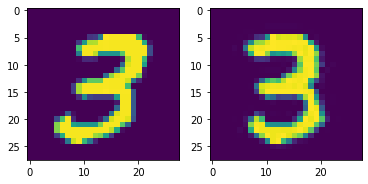

time: 247 ms (started: 2021-04-09 15:05:47 +00:00)


In [8]:
plt.subplot(1, 2, 1)
plt.imshow(train_images[7].reshape(28,28))

newim = deskew(train_images[7].reshape(28,28))
plt.subplot(1, 2, 2)
plt.imshow(newim)

All the images in the dataset were processed with deskewing.

In [9]:
def deskewAll(train_images):
    currents = []
    for i in range(len(train_images)):
        currents.append(deskew(train_images[i].reshape(28,28)).flatten())
    return np.array(currents)

train_images_deskewed = deskewAll(train_images)
test_images_deskewed = deskewAll(test_images)



time: 20.4 s (started: 2021-04-09 15:05:47 +00:00)


## Decision Tree
---

The first approach employed concern the generation of a ***decision tree***, a supervised learningh method used for both classification and regression problems. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. 

A decision tree is a predictive model, where each  internal node denotes a test on an attribute, each branch represents an outcome of the test, and each leaf node holds a class label.

In [10]:
from sklearn import tree
#reshaping data
train_images = train_images_deskewed.flatten().reshape(60000,784)
test_images = test_images_deskewed.flatten().reshape(10000,784)
#training the model
tree_clf = tree.DecisionTreeClassifier(max_depth=10)
tree_clf.fit(train_images,train_labels)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

time: 10.8 s (started: 2021-04-09 15:06:07 +00:00)


It is possible to visualize the tree that has been generated with the following code.

In [41]:
#import sys
#import os

#dtreeviz is a library that allows a nice visualization of the decision tree
#!pip install -q dtreeviz
#from dtreeviz.trees import *

time: 923 µs (started: 2021-04-09 15:47:55 +00:00)


In [42]:
#columns = [f'pixel[{i},{j}]' for i in range(28) for j in range(28)]

#tree_viz = dtreeviz(tree_clf, 
#               train_images_deskewed,
#               train_labels,
#               target_name='number',
#               feature_names=columns, 
#               class_names=str(tree_clf.classes_),
#               histtype='bar', orientation='TD',
#               fontname= 'Arial',
#               title= 'Decision Tree - MNIST')
#tree_viz


time: 1.4 ms (started: 2021-04-09 15:48:09 +00:00)


Once obtained our model, we can proceed with the testing phase. 

In [13]:
#testing the model
clf_predictons = tree_clf.predict(test_images)

time: 26.8 ms (started: 2021-04-09 15:08:23 +00:00)


The ***evaluation*** of the model is shown below:

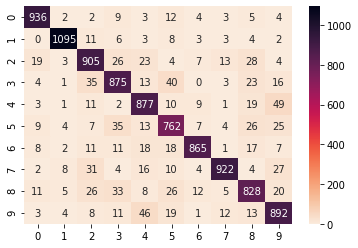

time: 842 ms (started: 2021-04-09 15:08:23 +00:00)


In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score

cf_matrix = confusion_matrix(test_labels, clf_predictons)
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="rocket_r")

In [15]:
accuracy_tree= accuracy_score(test_labels, clf_predictons)
print("Accuracy:", accuracy_tree)

Accuracy: 0.8957
time: 3.48 ms (started: 2021-04-09 15:08:23 +00:00)


The confusion matrix shows that most of the test set is well classified.
The model tends more to confuse and consequently to misclaffy the classes corresponding to the following digits:
- 3 and 5 
- 4 and 9

These digits appear to be similar, so the error may be somehow "justified". It is indeed very rare that a digit like "0" is predicted as "1", since their representations are totally different. 

The accuracy reached with this method is equal to 89%, which is not a bad result but we will see now other approaches that will significantly increase the performance.

## Random Forest
---

***Random forest*** is a learning method that consists of a large number of individual decision trees that operate as an ensemble. 


 operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, accuracy_score

time: 27.4 ms (started: 2021-04-09 15:08:23 +00:00)


The *n_estimators* hyperparameter represents the number of trees the algorithm builds before taking the maximum voting or taking the averages of predictions. In general, a higher number of trees increases the performance and makes the predictions more stable, but it also slows down the computation.

For this reason, we decided to see how the accuracy of the model may vary according to the number of the decision tree selected. 

In [18]:
n_tree=[10,30,60,90,100]
best_parameters={}

for i in n_tree:
  model = RandomForestClassifier(n_estimators=i)
  model.fit(train_images,train_labels)
  forest_predictions = model.predict(test_images)
  c_report = classification_report(test_labels, forest_predictions)
  accuracy = accuracy_score(test_labels,forest_predictions)
  best_parameters[i]=accuracy
  print("Classification Report with", i, "estimators",'\n',c_report, '\n', "Accuracy:", accuracy)
  


Classification Report with 10 estimators 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.94      0.96      0.95      1010
           4       0.95      0.97      0.96       982
           5       0.95      0.95      0.95       892
           6       0.97      0.97      0.97       958
           7       0.98      0.96      0.97      1028
           8       0.96      0.94      0.95       974
           9       0.96      0.93      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000
 
 Accuracy: 0.9632
Classification Report with 30 estimators 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       1.00    

In [19]:
max_accuracy = max(best_parameters, key=best_parameters.get)
print("Using", max_accuracy,"estimators, the accuracy of the prediction is the highest:",best_parameters[max_accuracy])


Using 100 estimators, the accuracy of the prediction is the highest: 0.9787
time: 2.24 ms (started: 2021-04-09 15:31:21 +00:00)


Now, we can focus on training and testing of our model with the best hyperparameter selected. 

In [21]:
model = RandomForestClassifier(n_estimators=max_accuracy)
model.fit(train_images,train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

time: 44.2 s (started: 2021-04-09 15:32:40 +00:00)


In [22]:
forest_predictions = model.predict(test_images)

time: 325 ms (started: 2021-04-09 15:33:59 +00:00)


In [23]:
c_report = classification_report(test_labels, forest_predictions)
print("Classification Report",'\n',c_report)

accuracy_RF = accuracy_score(test_labels,forest_predictions)
print("Accuracy: ",accuracy_RF)

Classification Report 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       1.00      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.97      0.98      0.97       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.99      0.98      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.97      0.96      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Accuracy:  0.9779
time: 30.6 ms (started: 2021-04-09 15:33:59 +00:00)


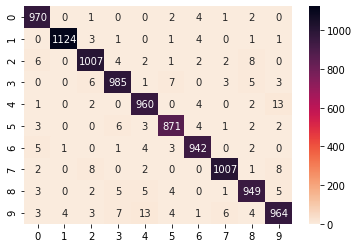

time: 516 ms (started: 2021-04-09 15:33:59 +00:00)


In [24]:
cf_matrix = confusion_matrix(test_labels, forest_predictions)
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="rocket_r")

It is evident that the Random Forest classifier performed better than the simpler Decision Tree. The accuracy increased up to 97%.

## CNN
---

***Convolutional neural networks*** (CNNs) are the current state-of-art architecture for image classification task. CNN takes the image's raw pixel data as input and "learns" how to extract these features, applying one or more filters and ultimately infer what object they constitute. CNN uses some layers to gather information and determine some features from the image.

###Data preparation

Reshape the data arrays in order to have a single color channel. 

In [25]:
train_images = train_images_deskewed.reshape(train_images_deskewed.shape[0], 28, 28, 1)
test_images = test_images_deskewed.reshape(test_images_deskewed.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

time: 1.54 ms (started: 2021-04-09 15:34:00 +00:00)


Pixel intensity values for each image in the dataset are integers in the range between balck and white (0 to 255). We can now normalize the pixel values of greyscale images converting them from unsigned integers to floats and then rescaling them to the range [0,1]. 

In [26]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images = train_images / 255.0
test_images = test_images / 255.0

time: 84.1 ms (started: 2021-04-09 15:34:00 +00:00)


Given the 10 classes (labels) which are represented as unique integers, it is possible to use a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with:
- 1 for the index of the class value 
- 0 values for all other classes. 

We can do this with *to_categorical()* utility function.

In [27]:
from keras.utils.np_utils import to_categorical

nclasses = 10
train_labels = to_categorical(train_labels, num_classes = nclasses )
test_labels = to_categorical(test_labels, num_classes = nclasses )
print("Shape of train_labels: ", train_labels.shape) 
print("Shape of test_labels: ", test_labels.shape)

Shape of train_labels:  (60000, 10)
Shape of test_labels:  (10000, 10)
time: 38.9 ms (started: 2021-04-09 15:34:00 +00:00)


### Building the model


In [28]:
#import modules
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import Adam

time: 2.9 ms (started: 2021-04-09 15:34:00 +00:00)


The model has two main aspects: the ***feature extraction front-end*** comprised of convolutional and pooling layers, and the ***classifier back-end*** that will make a prediction.

The architecture followed here is a **2D convolutional layer** with a small filter size (3,3) and a modest number of filters (32) followed by a **maxpooling layer**. The filter maps can then be flattened to provide features to the classifier.

Given that the problem is a multi-class classification task, we will require an output layer with 10 nodes in order to predict the probability distribution of an image belonging to each of the 10 classes. This will also require the use of a ***softmax activation function***. Between the feature extractor and the output layer, we add a **dense layer** to interpret the features, in this case with 100 nodes.

All layers will use the ***ReLU activation function*** and the ***He weight*** initialization scheme.

In [29]:
#create model
model = Sequential()
#add model layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(nclasses, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               540900    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
_________________________________________________________________
time: 5.32 s (started: 2021-04-09 15:34:00 +00:00)


Compiling the model takes 3 hyperparameters: ***optimizer***, ***loss*** and ***performance metrics***.

- The optimizer controls the learning rate. We will be using ***adam** that adjusts the learning rate throughout training.

- We will use ***categorical_crossentropy*** as the loss function.

- We will use the ***accuracy*** performance metric to see the accuracy score on the validation set when we train the model.

In [30]:
#compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

time: 10.8 ms (started: 2021-04-09 15:34:05 +00:00)


After the model architecture is defined and compiled, the model needs to be trained with training data to be able to recognize the handwritten digits. Hence, we will fit the model with *train_images* and *train_labels*.

In [31]:
epochs = 25
batch_size = 256
#model training
history = model.fit(x=train_images, 
                    y=train_labels, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_split=0.1)

Epoch 1/25
211/211 [==============================] - 34s 7ms/step - loss: 0.4029 - accuracy: 0.8743 - val_loss: 0.0666 - val_accuracy: 0.9833
Epoch 2/25
211/211 [==============================] - 1s 5ms/step - loss: 0.0664 - accuracy: 0.9797 - val_loss: 0.0480 - val_accuracy: 0.9865
Epoch 3/25
211/211 [==============================] - 1s 5ms/step - loss: 0.0375 - accuracy: 0.9895 - val_loss: 0.0421 - val_accuracy: 0.9878
Epoch 4/25
211/211 [==============================] - 1s 5ms/step - loss: 0.0256 - accuracy: 0.9923 - val_loss: 0.0382 - val_accuracy: 0.9900
Epoch 5/25
211/211 [==============================] - 1s 5ms/step - loss: 0.0192 - accuracy: 0.9944 - val_loss: 0.0380 - val_accuracy: 0.9887
Epoch 6/25
211/211 [==============================] - 1s 5ms/step - loss: 0.0172 - accuracy: 0.9952 - val_loss: 0.0371 - val_accuracy: 0.9900
Epoch 7/25
211/211 [==============================] - 1s 6ms/step - loss: 0.0116 - accuracy: 0.9969 - val_loss: 0.0341 - val_accuracy: 0.9907
Epoch

The number of ***epochs*** is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset. 
One epoch means that each sample in the training set has had an opportunity to update the internal model parameters. An epoch is comprised of one or more batches.

The ***batch size*** is another hyperparameter that defines the number of samples to work through before updating the internal model parameters.


Now, the trained model needs to be evaluated in terms of performance.

In [32]:
score = model.evaluate(test_images,test_labels)
print("Test loss:", score[0])
accuracy_cnn= score[1]
print("Test accuracy:", accuracy_cnn)

313/313 [==============================] - 1s 2ms/step - loss: 0.0398 - accuracy: 0.9901
Test loss: 0.03983662277460098
Test accuracy: 0.9901000261306763
time: 722 ms (started: 2021-04-09 15:35:06 +00:00)


It is possible to visualize the whole training log and capture information about loss and accuracy of the model on training and testing data.

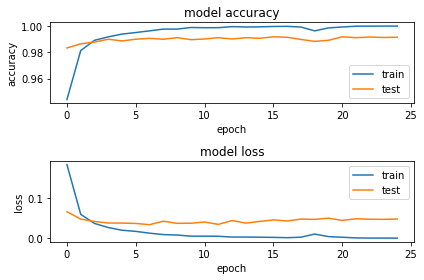

time: 336 ms (started: 2021-04-09 15:35:07 +00:00)


In [33]:
fig = plt.figure() 
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper right')

plt.tight_layout()


Given this learning curve, it is possible to notice that the loss on the training set is decreasing rapidly for the first few epochs. This means that the model is learning to classify the digits fast. However, for the test set the loss does not decrease as fast, but stays roughly within the same range as the training loss. 

Our model seems to generalized pretty well to unseen data, but in the next and last step of this project we will  implement an improved model. 

### Improved model

There are many ways to change the model configuration in order to explore improvements over the baseline model.

It is possible to ***increase the depth*** of the feature extractor part of the model, adding more convolutional and pooling layers with the same sized filter, while increasing the number of filters. In this case, we will add another 2D convolutional layer with 64 filters each, followed by another max pooling layer.

Moreover, after both maxpooling and fully connected layer, ***dropout*** is introduced as regularization in our model to reduce overfitting problems.

In [34]:
#create model
model = Sequential()
#add model layers
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(MaxPool2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nclasses, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)             

In [35]:
#compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

time: 7.76 ms (started: 2021-04-09 15:35:08 +00:00)


In [36]:
epochs = 25
batch_size = 256
#train the model
history = model.fit(x=train_images, 
                    y=train_labels, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_split=0.1)

Epoch 1/25
211/211 [==============================] - 3s 12ms/step - loss: 0.8161 - accuracy: 0.7440 - val_loss: 0.1013 - val_accuracy: 0.9715
Epoch 2/25
211/211 [==============================] - 2s 10ms/step - loss: 0.1711 - accuracy: 0.9463 - val_loss: 0.0601 - val_accuracy: 0.9828
Epoch 3/25
211/211 [==============================] - 2s 11ms/step - loss: 0.1151 - accuracy: 0.9646 - val_loss: 0.0475 - val_accuracy: 0.9862
Epoch 4/25
211/211 [==============================] - 2s 11ms/step - loss: 0.0933 - accuracy: 0.9705 - val_loss: 0.0425 - val_accuracy: 0.9885
Epoch 5/25
211/211 [==============================] - 2s 11ms/step - loss: 0.0795 - accuracy: 0.9743 - val_loss: 0.0325 - val_accuracy: 0.9910
Epoch 6/25
211/211 [==============================] - 2s 11ms/step - loss: 0.0672 - accuracy: 0.9791 - val_loss: 0.0298 - val_accuracy: 0.9925
Epoch 7/25
211/211 [==============================] - 2s 11ms/step - loss: 0.0602 - accuracy: 0.9813 - val_loss: 0.0287 - val_accuracy: 0.9917

In [37]:
score = model.evaluate(test_images,test_labels)
print("Test loss:", score[0])
accuracy_impr_cnn= score[1]
print("Test accuracy:", accuracy_impr_cnn)

313/313 [==============================] - 1s 2ms/step - loss: 0.0197 - accuracy: 0.9939
Test loss: 0.019747361540794373
Test accuracy: 0.9939000010490417
time: 791 ms (started: 2021-04-09 15:36:04 +00:00)


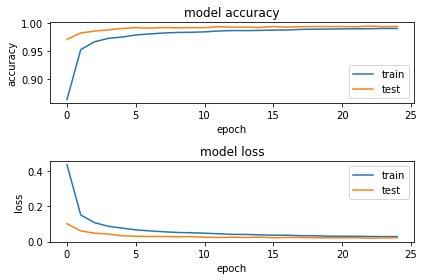

time: 339 ms (started: 2021-04-09 15:36:05 +00:00)


In [38]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper right')

plt.tight_layout()

If we visualize the whole training log, then with more number of epochs the loss and accuracy of the model on training and testing data converged thus making the model a stable one.

So, the improved model does not suffer from overfitting. The accuracy reached more than 99%. 

***Inspecting the prediction output***

It is possible to analize which images are correctly predicted and which not. 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


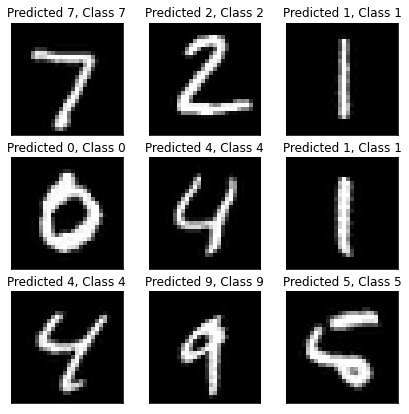

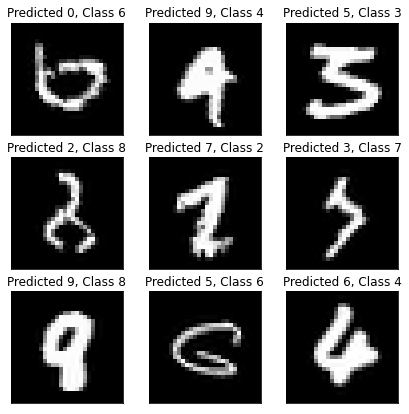

time: 1.03 s (started: 2021-04-09 15:36:05 +00:00)


In [39]:
predicted_classes = model.predict_classes(test_images)
correct_indices   = np.nonzero(predicted_classes == test_labels.argmax(axis=-1))[0]
incorrect_indices = np.nonzero(predicted_classes != test_labels.argmax(axis=-1))[0]

plt.figure(1, figsize=(7,7))
#plot 9 correct predictions
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_images[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_labels[correct].argmax(axis=-1)))
    plt.xticks([])
    plt.yticks([])
    
plt.figure(2, figsize=(7,7))
#plot 9 incorrect predictions
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_images[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_labels[incorrect].argmax(axis=-1)))
    plt.xticks([])
    plt.yticks([])

As we can see, the wrong predictions are quite forgiveable since they are in some cases even hard to recognize for the human reader. 

## Conclusion
---

In this project, we have successfully built several machine learning models on handwritten digit classification. 

Simple models such as *Decision Tree* do not achieve a very high accuracy. *Random Forest* performed surprisingly well, was easy to train, and fairly quick. 

However, the *CNN improved model* performed the best out of all the models tested.  

In [40]:
accuracy= {'Methods': ["Decison Tree", "Random Forest", "CNN", "CNN improved"],
           'Accuracy': [accuracy_tree, accuracy_RF, accuracy_cnn, accuracy_impr_cnn]}
           
df=pd.DataFrame(accuracy, columns=['Methods','Accuracy'])
df.sort_values(by='Accuracy', ascending=True)

,Methods,Accuracy
0,Decison Tree,0.8957
1,Random Forest,0.9779
2,CNN,0.9901
3,CNN improved,0.9939


time: 25.8 ms (started: 2021-04-09 15:36:06 +00:00)


*The time needed to run all the code in this notebook is ~10 minutes using the GPU as hardware accelerator.*